In [1]:
import glob
import re
import pandas as pd
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
pattern = re.compile(r"\.\./\.\./legal-networks-data/us_reg/1_input/(?P<y1>\d+)/title-(?P<t1>\d+)/CFR-(?P<y>\d+)-title(?P<t>\d+)-vol(?P<v>\d+).xml")

matches = [
    pattern.fullmatch(p).groupdict() 
    for p in glob.glob('../../legal-networks-data/us_reg/1_input/*/*/*.xml')
    if not p.endswith('1997/title-21/CFR-1997-title21-vol.xml') # this file is poorly formatted but it is not in the years we assess
]

if not matches:
    print('Please unzip all files in legal-networks-data/us_reg/1_input/')

In [3]:
df = pd.DataFrame(matches)
assert len(df[df.y1 != df.y]) == 0
assert len(df[df.t1 != df.t]) == 0
df = df.drop(['y1', 't1'], axis=1)


In [4]:
df.v = [int(v) for v in df.v]
df.y = [int(y) for y in df.y]
df.t = [int(t) for t in df.t]
df = df.sort_values(['y', 't', 'v']).reset_index().drop('index', axis=1)

In [5]:
def prev_missing(df, idx):
    row = df.iloc[idx]
    if int(row.v) == 1:
        return False
    else:
        prev = df.iloc[idx-1]
        if not (
            row.y == prev.y and
            row.t == prev.t and
            row.v == prev.v + 1
        ):
#             print(list(row), list(prev))
            return True
        else:
            return False

df['prev_missing'] = [prev_missing(df, i) for i in range(len(df))]

In [6]:
volume_counts = df.groupby(['y', 't']).count()['v']

In [7]:
df_desc = df.groupby(['y', 't'])['v'].describe()

In [8]:
df['y_t_max'] = [int(df_desc['max'][y, t]) for y, t in zip(df.y, df.t)]
df['y_t_count'] = [int(df_desc['count'][y, t]) for y, t in zip(df.y, df.t)]
df['y_t_diff'] = df['y_t_count'] - df['y_t_max']

In [9]:
df

,y,t,v,prev_missing,y_t_max,y_t_count,y_t_diff
0,1996,21,1,False,9,9,0
1,1996,21,2,False,9,9,0
2,1996,21,3,False,9,9,0
3,1996,21,4,False,9,9,0
4,1996,21,5,False,9,9,0
...,...,...,...,...,...,...,...
5223,2020,40,22,True,36,7,-29
5224,2020,40,23,False,36,7,-29
5225,2020,40,35,True,36,7,-29
5226,2020,40,36,False,36,7,-29


In [10]:
y_max = df.y.max()

In [11]:
def missing_next_year(row, df):
    if y_max == row.y:
        return None
    return not bool(len(df[
        (df.y==row.y+1)&
        (df.t==row.t)&
        (df.v==row.v)
    ]))

df['missing_next_year'] = [missing_next_year(row, df) for i, row in df.iterrows()]

In [12]:
df.to_csv('../results/us_missing_volumes_in_next_year.csv')
df.to_excel('../results/us_missing_volumes_in_next_year.xlsx')

In [13]:
missing_volumes_inferred_by_prev_year = {(row.y+1, row.t, row.v) for _, row in df[df.missing_next_year.fillna(False)].iterrows()}

In [14]:
missing_volumes_inferred_by_next_vol = {(row.y, row.t, row.v-1) for _, row in df[df.prev_missing].iterrows()}

In [15]:
len(missing_volumes_inferred_by_next_vol), len(missing_volumes_inferred_by_prev_year), len(missing_volumes_inferred_by_next_vol | missing_volumes_inferred_by_prev_year)

(54, 173, 185)

In [16]:
tuples = sorted({(t, v) for t, v in zip(df.t, df.v)}, reverse=True)
index = pd.MultiIndex.from_tuples(tuples, names=["t", "v"])

In [17]:
map_df = pd.DataFrame(columns=sorted(df.y.unique()), index=index)
for _, row in df.iterrows():
    map_df.loc[row.t, row.v][row.y] = 1

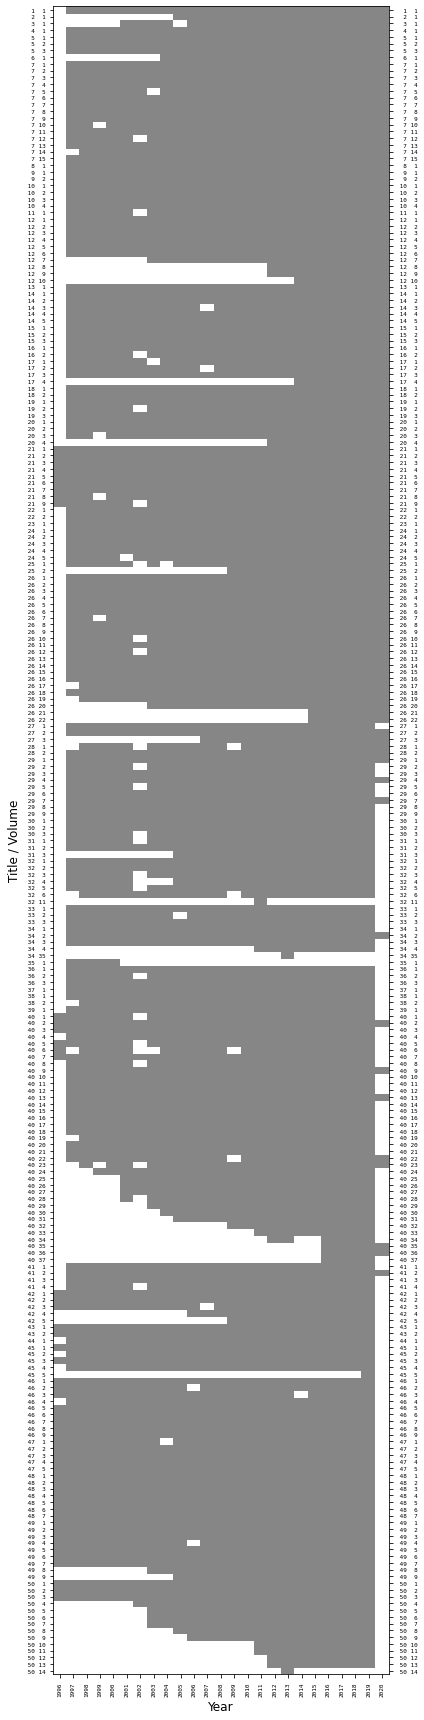

In [18]:
plt.figure(figsize=(6,24))
plt.tick_params(labelright=True, right=True)
plt.pcolor(map_df.fillna(0), cmap=cm.get_cmap('Greys'), vmax=1.8)
plt.yticks(np.arange(0.5, len(map_df.index), 1), [f'{t:3} {v:2}' for t, v in map_df.index], fontsize=6, fontname='monospace')
plt.xticks(np.arange(0.5, len(map_df.columns), 1), map_df.columns, fontsize=6, rotation=90, fontname='monospace')
plt.ylabel('Title / Volume', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.tight_layout()

plt.savefig('../graphics/missing-volumes-in-cfr.pdf')

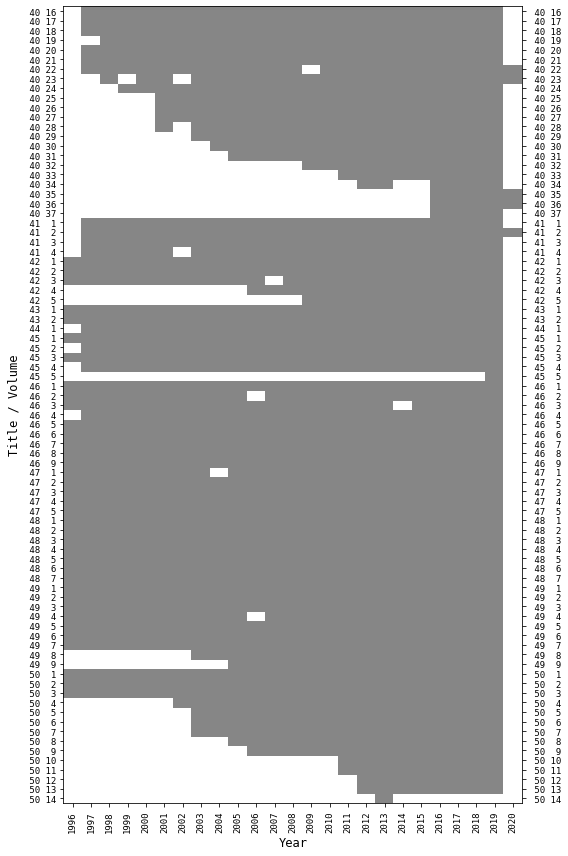

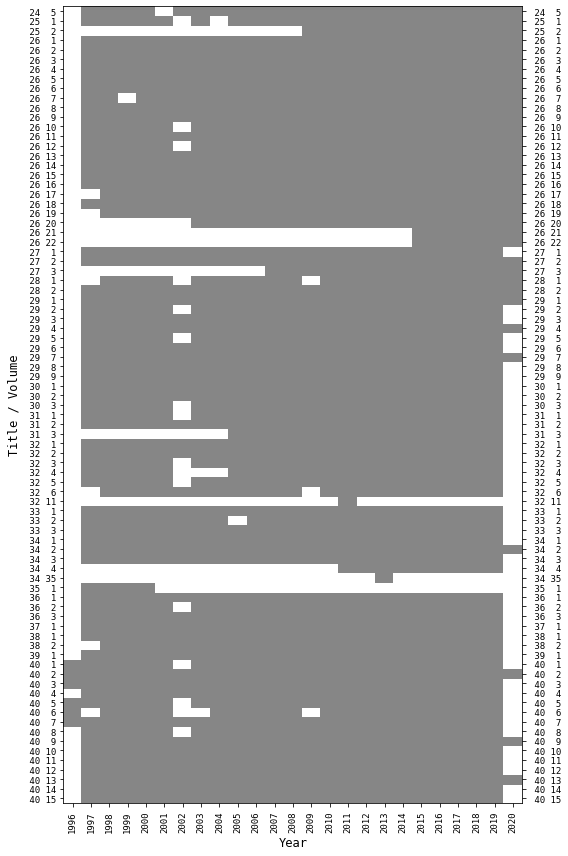

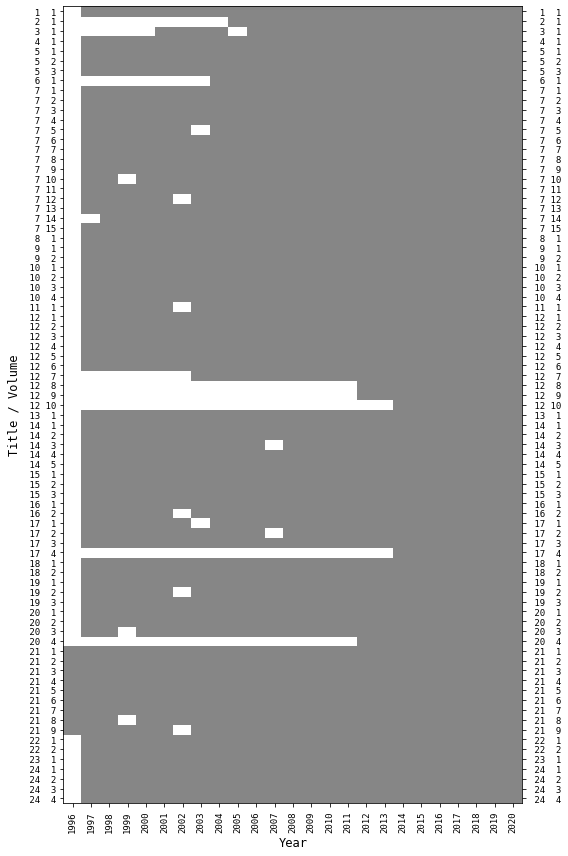

In [19]:
approx_length = int(len(map_df)/3)+1
for i in range(3):
    map_df_partial = map_df[approx_length*i:approx_length*(i+1)]
    plt.figure(figsize=(8,12))
    plt.tick_params(labelright=True, right=True)
    plt.pcolor(map_df_partial.fillna(0), cmap=cm.get_cmap('Greys'), vmax=1.8)
    plt.yticks(np.arange(0.5, len(map_df_partial.index), 1), [f'{t:3} {v:2}' for t, v in map_df_partial.index], fontsize=9, fontname='monospace')
    plt.xticks(np.arange(0.5, len(map_df_partial.columns), 1), map_df_partial.columns, fontsize=9, rotation=90, fontname='monospace')
    plt.xlabel("Year", fontname='monospace', fontsize=12)
    plt.ylabel("Title / Volume", fontname='monospace', fontsize=12)
    plt.tight_layout()

    plt.savefig(f'../graphics/missing-volumes-in-cfr-partial-{2-i}.pdf')